In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, shutil, re
from collections import Counter
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
from sklearn import manifold
from nltk.corpus.reader import PlaintextCorpusReader
from adjustText import adjust_text 
from sklearn.feature_extraction.text import TfidfTransformer


In [3]:
bpath = '/Users/erickpeirson/Jana/text Corpus 1'
target = '/Users/erickpeirson/Jana/text1_clean'

In [4]:
technocratic = [
    'stakeholder',
    'decision maker',
    'implement',
    'input',
    'output',
    'effecti[a-z]*',
    'scrutiniz[a-z]*',
    'verif[a-z]*',
    'test[a-z]*',
    'expert[a-z]*',
    'policy',
    'state',
    'reform',
    'govern[a-z]*',
    'solution',
    'solv[a-z]*',
    'supervis[a-z]*',
    'regulat[a-z]*',
]

In [5]:
deliberative = [
    'partn[a-z]*',
    'collaborat[a-z]*',
    'subj[a-z]*',
    'revol[a-z]*',
    'co-design',
    'engag[a-z]*',
    'empow[a-z]*',
    'interpret[a-z]*',
    'learn[a-z]*',
    'explor[a-z]*',
    'tacit knowl[a-z]*',
    'socially robust',
    'reflect[a-z]*',
    'disput[a-z]*',
    'civil soc[a-z]*',
    'lifeworld',
    'joint understanding',
    'mutual[a-z]*',
    'dillemm[a-z]*',
    'coordinat[a-z]*',
    'align[a-z]*',
    'arrang[a-z]*',
]

In [6]:
vocabulary = technocratic + deliberative

In [7]:
for fname in os.listdir(bpath):
    fpath = os.path.join(bpath, fname)
    tpath = os.path.join(target, unidecode(fname.decode('utf-8')))
    shutil.copy(fpath, tpath)

In [7]:
filenames = os.listdir(target)[1:]

In [8]:
technocratic_data = np.ndarray((len(filenames),    # Each document.
                                len(technocratic)))   # Each word (in techocratic).
deliberative_data = np.ndarray((len(filenames), len(deliberative)))

In [9]:
document_size = np.ndarray((len(filenames),))

In [10]:
term_counts = np.ndarray((len(filenames), len(vocabulary)))

In [11]:
for i, fname in enumerate(filenames):
    fpath = os.path.join(target, fname)
    with open(fpath, 'r') as f:
        raw = f.read().lower().decode('utf-8')
    for j, term in enumerate(technocratic):
        technocratic_data[i, j] = len(re.findall(term, raw, flags=re.U))
    for j, term in enumerate(deliberative):
        deliberative_data[i, j] = len(re.findall(term, raw, flags=re.U))
    for j, term in enumerate(vocabulary):
        term_counts[i, j] = len(re.findall(term, raw, flags=re.U))
        
    document_size[i] = len(raw.split())
    print '\r', fname, i,
    

Zurayk-2011-Ensuring that potential Gulf farml.txt 1313


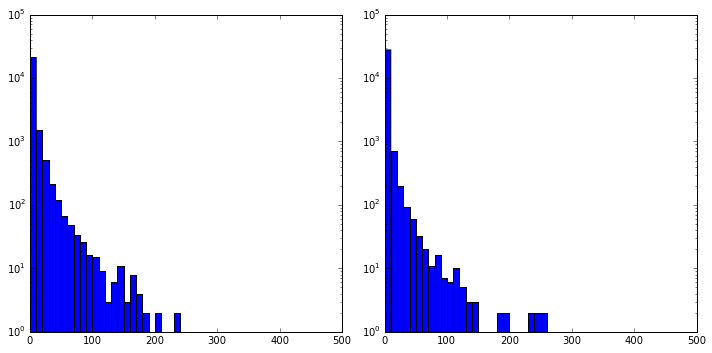

In [12]:
plt.figure(figsize(10, 5))
plt.subplot(121)
plt.hist(technocratic_data.flat, log=True, bins=np.arange(0, 500, 10))
plt.subplot(122)
plt.hist(deliberative_data.flat, log=True, bins=np.arange(0, 500, 10))
plt.tight_layout()
plt.show()

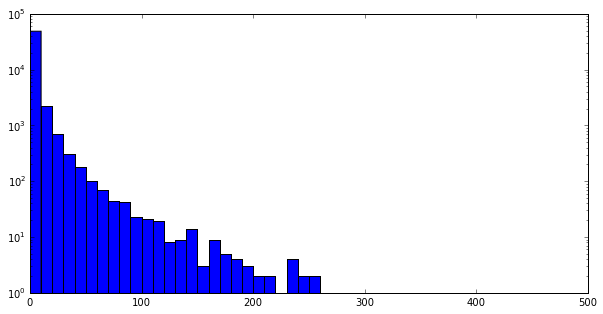

In [13]:
plt.hist(term_counts.flat, log=True, bins=np.arange(0, 500, 10))
plt.show()

In [14]:
term_counts_masked = np.ma.MaskedArray(term_counts, not np.isnan)

In [15]:
term_frequency = (term_counts_masked.T/term_counts_masked.sum(axis=1)).T

In [16]:
term_frequency.shape

(1314, 40)

In [19]:
_D_freq = deliberative_data.sum(axis=1)/(document_size * len(vocabulary))
_T_freq = technocratic_data.sum(axis=1)/(document_size * len(vocabulary))

In [29]:
_D = (deliberative_data.sum(axis=1)/document_size) - (technocratic_data.sum(axis=1)/document_size)
_D /= _D.max()
_T = (technocratic_data.sum(axis=1)/document_size) - (deliberative_data.sum(axis=1)/document_size)
_T /= _T.max()

In [20]:
_T_idx = [filenames.index(fname) for fname in list(np.array(filenames)[_T_freq.argsort()[::-1][:10]])]
_T_tf = term_frequency[_T_idx]/10.
_T_order = _T_tf.sum(axis=0).argsort()[::-1]
_T_sorted_values = dict(zip(np.array(vocabulary)[_T_order], _T_tf.sum(axis=0)[_T_order]))

_D_idx = [filenames.index(fname) for fname in list(np.array(filenames)[_D_freq.argsort()[::-1][:10]])]
_D_tf = term_frequency[_D_idx]/10.
_D_order = _D_tf.sum(axis=0).argsort()[::-1]
_D_sorted_values = dict(zip(np.array(vocabulary)[_D_order], _D_tf.sum(axis=0)[_D_order]))

In [21]:
_D_bar_values = [_D_sorted_values[t] for t in vocabulary]
_T_bar_values = [_T_sorted_values[t] for t in vocabulary]

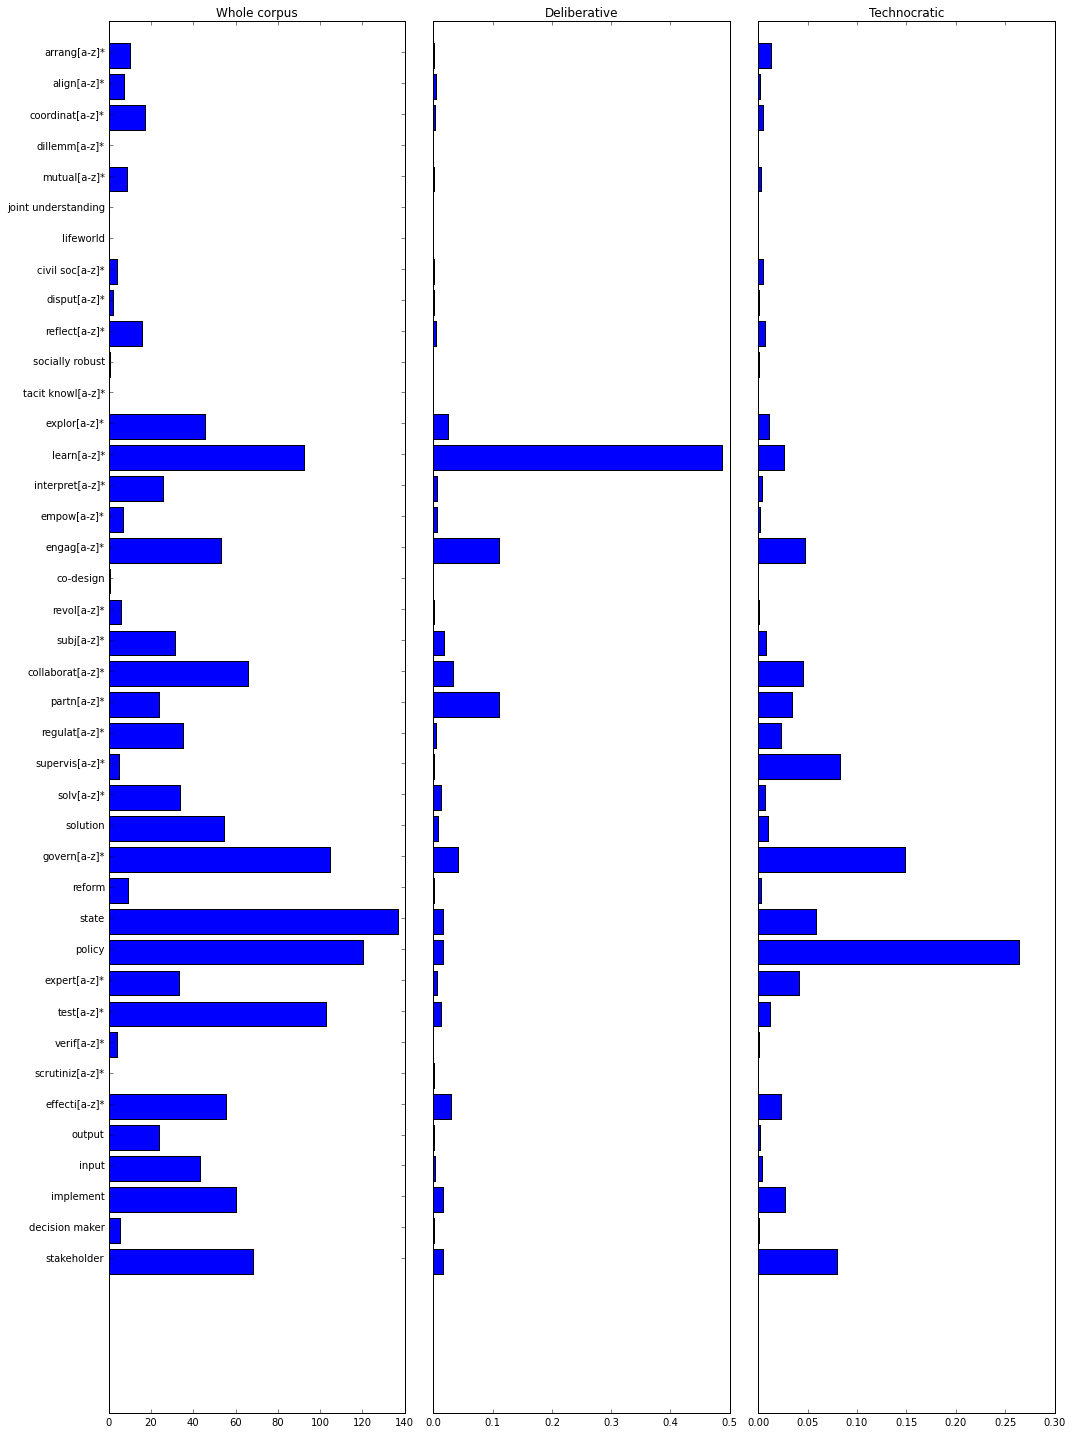

In [22]:
plt.figure(figsize=(15, 20))
plt.subplot(131)
plt.barh(np.arange(40)-0.5, term_frequency.sum(axis=0))
plt.yticks(np.arange(40), vocabulary)
plt.title('Whole corpus')

plt.subplot(132)
plt.barh(np.arange(40)-0.5, _D_bar_values)
plt.yticks([], [])
plt.title('Deliberative')
# plt.xlim(0, 0.5)

plt.subplot(133)
plt.barh(np.arange(40)-0.5, _T_bar_values)
plt.yticks([], [])
plt.title('Technocratic')
# plt.xlim(0, 0.5)
plt.tight_layout()
plt.show()

In [66]:
mds = manifold.SpectralEmbedding(n_components=2, random_state=6)
results = mds.fit(term_frequency)

In [67]:
coords = results.embedding_

In [68]:
c = cmap=plt.get_cmap('YlOrRd')

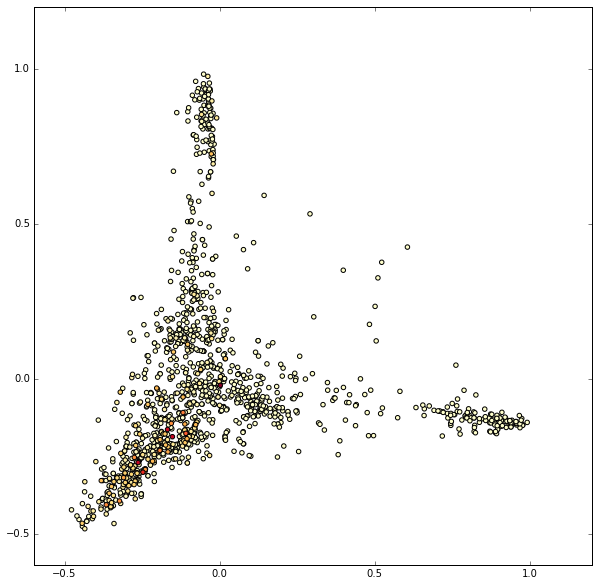

In [83]:
plt.figure(figsize=(10, 10))
plt.scatter(coords[_D.argsort()[::-1]][:, 0], 
            coords[_D.argsort()[::-1]][:, 1], 
            marker = 'o', c=[c(_d) for _d in list(np.sort(_D))])
plt.show()

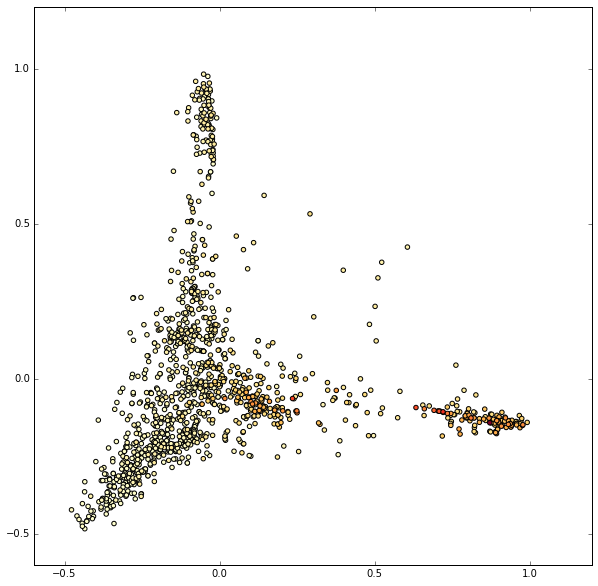

In [84]:
plt.figure(figsize=(10, 10))
plt.scatter(coords[_T.argsort()[::-1]][:, 0], 
            coords[_T.argsort()[::-1]][:, 1], 
            marker = 'o', c=[c(_d) for _d in list(np.sort(_T))])
plt.show()

In [85]:
print '\n'.join(list(np.array(filenames)[_T_freq.argsort()[::-1][:10]]))

Grossman-2015-Co-supervision in postgraduate t.txt
Primmer-2015-Governance of Ecosystem Services_.txt
Spruijt-2014-Roles of scientists as policy adv.txt
Niles-2012-Integrative Frontiers in Environmen.txt
Schut-2014-Towards dynamic research configurat.txt
Andonova-2014-Boomerangs to Partnerships_ Expl.txt
Abbott-2012-Engaging the public and the privat.txt
Cook-2015-Policy Mobilities and Interdisciplin.txt
Gollagher-2013-The role of deliberative collab.txt
Jolibert-2012-Research impacts and impact on r.txt


In [86]:
print '\n'.join(list(np.array(filenames)[_D_freq.argsort()[::-1][:10]]))

Tomas-2015-Promoting online students' engageme.txt
Guthrie-2014-Reflection_ the importance of mak.txt
Skinner-2012-Intrinsic motivation and engageme.txt
Moyer-2014-Learning for sustainability among f.txt
Diamond-2013-Using e-learning for student sust.txt
Hutchins-2013-Strengthening knowledge co-produ.txt
Almeida-2015-The WalkAbout framework for conte.txt
Mert-2014-Hybrid governance mechanisms as poli.txt
Medema-2014-Multi-Loop Social Learning for Sus.txt
Shaw-2014-A catalyst toward sustainability_ Ex.txt


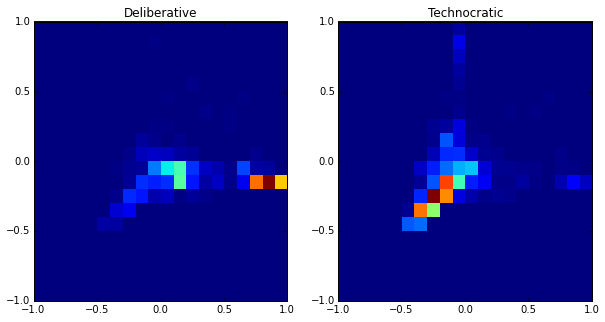

In [89]:
plt.figure(figsize=(10, 5))
subplot(121)
_c = []
for i, j, f in zip(coords[:, 0], coords[:, 1], _D_freq**2):
    _c +=[(i, j) for _ in xrange(int(np.floor(f*10e10)))]

x, y = zip(*_c)
plt.title('Deliberative')
plt.hist2d(x, y, bins=20, range=[[-1, 1], [-1, 1]])

plt.subplot(122)
_c = []
for i, j, f in zip(coords[:, 0], coords[:, 1], _T_freq**2):
    _c +=[(i, j) for _ in xrange(int(np.floor(f*10e10)))]

x, y = zip(*_c)
plt.hist2d(x, y, bins=20, range=[[-1, 1], [-1, 1]])
plt.title('Technocratic')
plt.show()

In [49]:
mds = manifold.SpectralEmbedding(n_components=2, random_state=6)
results = mds.fit(term_frequency.T)
_coords = results.embedding_

In [50]:
colors = ['r' if t in technocratic else 'b' for t in vocabulary]

In [52]:
sizes = [term_frequency[:, i].sum()*5. for i, t in enumerate(vocabulary)]

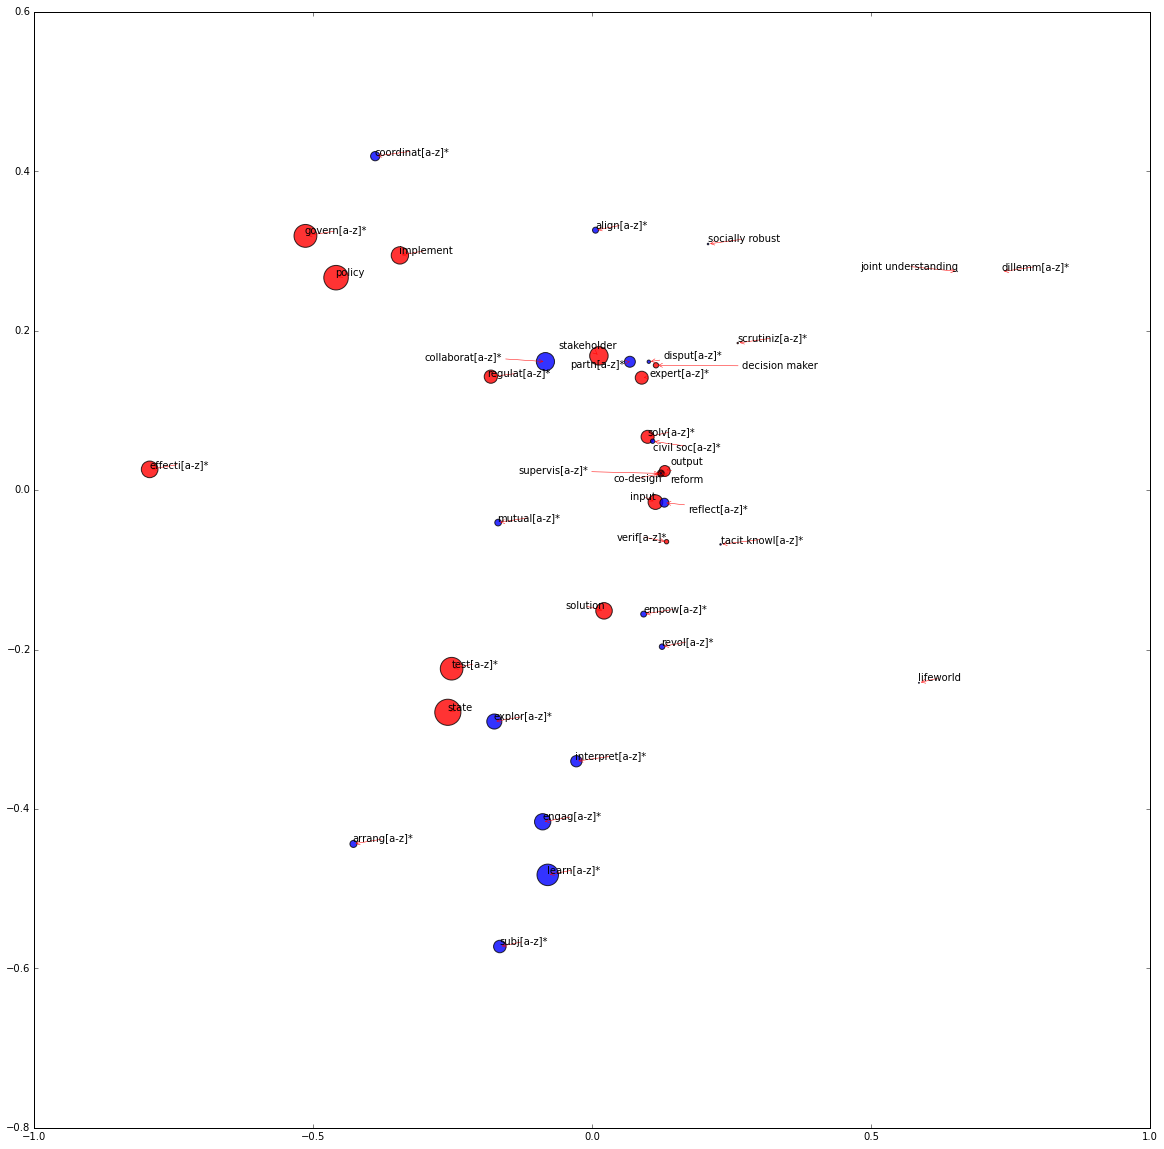

In [53]:
plt.figure(figsize=(20, 20))


plt.scatter(_coords[:, 0], _coords[:, 1], marker = 'o', c=colors, s=sizes, alpha=0.8)
t = []
for i, term in enumerate(vocabulary):
    t.append(plt.text(_coords[i, 0], _coords[i, 1], term))
adjust_text(t, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), force_points=0.5, expand_points=(0.9, 0.9))
plt.show()

In [54]:
mds = manifold.Isomap(n_components=2)
results = mds.fit(term_frequency.T)
_coords = results.embedding_

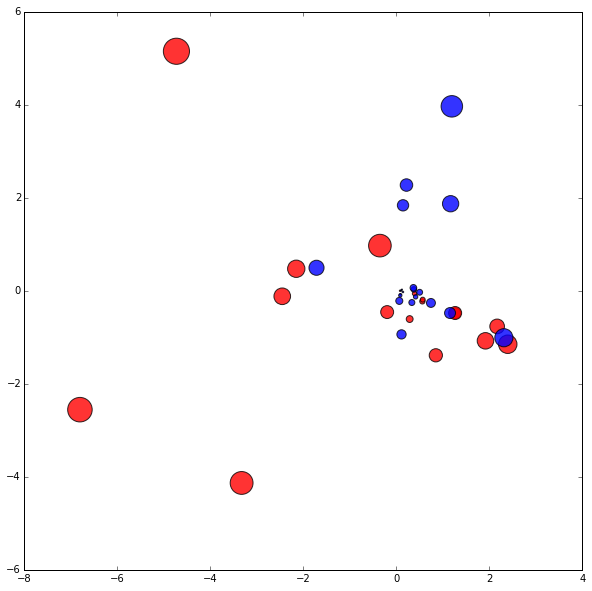

In [55]:
plt.figure(figsize=(10, 10), dpi=600)

plt.scatter(_coords[:, 0], _coords[:, 1], marker = 'o', c=colors, s=sizes, alpha=0.8)
# t = []
# for i, term in enumerate(vocabulary):
#     t.append(plt.text(_coords[i, 0], _coords[i, 1], term))
# adjust_text(t, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), force_points=0.5, expand_points=(0.9, 0.9))
plt.show()

In [56]:
mds = manifold.MDS(n_components=2)
results = mds.fit(term_frequency.T)
_coords = results.embedding_

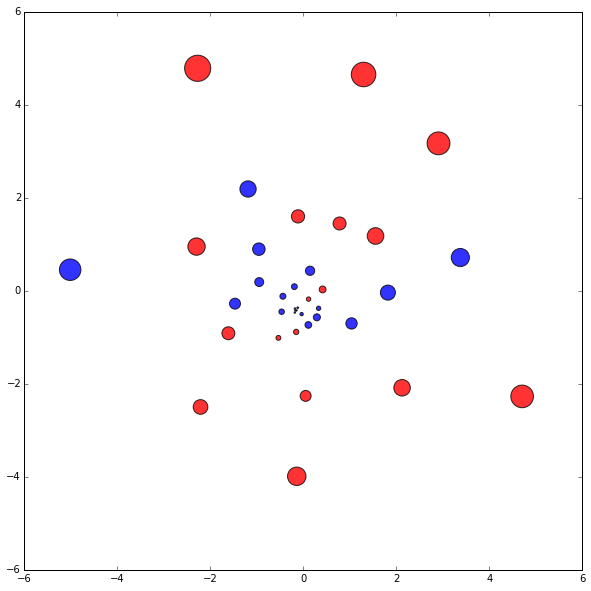

In [57]:
plt.figure(figsize=(10, 10), dpi=600)

plt.scatter(_coords[:, 0], _coords[:, 1], marker = 'o', c=colors, s=sizes, alpha=0.8)
# t = []
# for i, term in enumerate(vocabulary):
#     t.append(plt.text(_coords[i, 0], _coords[i, 1], term))
# adjust_text(t, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), force_points=0.5, expand_points=(0.9, 0.9))
plt.show()

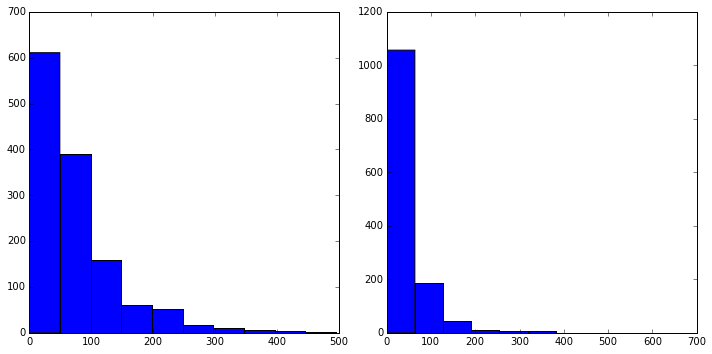

In [58]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(technocratic_data.sum(axis=1))

plt.subplot(122)
plt.hist(deliberative_data.sum(axis=1))
plt.tight_layout()
plt.show()

(-0.05, 2.0)

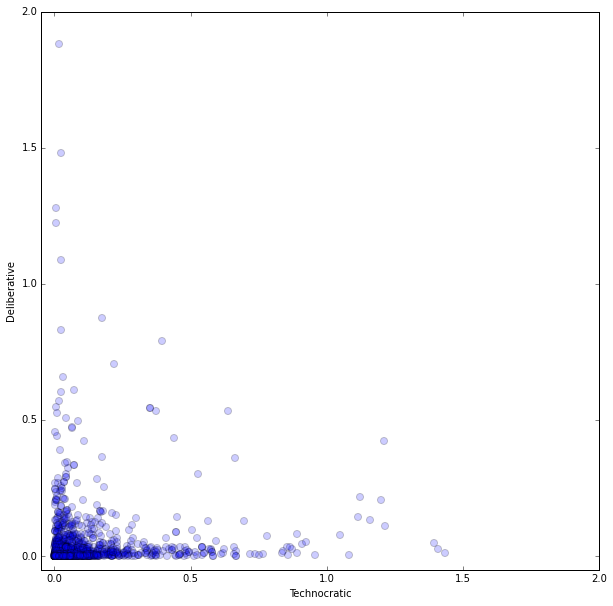

In [64]:
plt.figure(figsize=(10, 10))
technocratic_tx = 1e3*(technocratic_data.sum(axis=1)/document_size)**2.
deliberative_tx = 1e3*(deliberative_data.sum(axis=1)/document_size)**2.
plt.scatter(technocratic_tx, deliberative_tx, alpha=0.2, s=50)
plt.ylabel('Deliberative')
plt.xlabel('Technocratic')
plt.xlim(-0.05, 2.)
plt.ylim(-0.05, 2.)